# ML_2Type

establish a 2 type classifier for E/NE data. 'effc': 0=E; 1=NE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec #for PCA
import numpy as np
import seaborn as sns
import os
import time

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

save_dir = 'input your file dir' #r'E:\Github'

# Function

In [2]:
from sklearn.model_selection import GridSearchCV

def GridSearch_result(ML, X, y, param_grid, cv=3, score="accuracy"):
    start = time.time()
    grid_search = GridSearchCV(ML, param_grid, cv=cv, scoring=score, refit=True)
    grid_search.fit(X, y)
    end = time.time()
    print("Run Time:%s s" % (end-start))
    return [grid_search.best_params_, grid_search.best_estimator_]

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score  #AUC

def ML_result(ML, X, y, label, roc=0, feedback=0, save_dir=None,
              cmap=sns.color_palette('tab10'), cv=3, ):
    "Input: ML classifier. "
    "fit, and Output confusion_matrix, accuracy_score / roc_curve"
    
    ML.fit(X, y)
    y_pred = cross_val_predict(ML, X, y, cv=cv)
    
    conf_mat = confusion_matrix(y, y_pred)
    accu = accuracy_score(y, y_pred)
    if roc != 0:
        if roc == "rf":
            y_probas_forest = cross_val_predict(ML, X, y, cv=cv, method="predict_proba")
            y_scores = y_probas_forest[:, 1] # score = proba of positive class
        if roc == "sgd":
            y_scores = cross_val_predict(ML, X, y, cv=cv, method="decision_function")
        fpr, tpr, thresholds = roc_curve(y, y_scores)
        auc = roc_auc_score(y, y_scores)
        plot_roc_curve([fpr], [tpr], label=[label], auc=[auc], cmap=cmap, save_dir=save_dir)
        plt.show()
        if feedback == 1:
            return {"conf_mat":conf_mat, "accu":accu, "auc":auc, "fpr":fpr, "tpr":tpr}
        else:
            return {"conf_mat":conf_mat, "accu":accu, "auc":auc}
    return {"conf_mat":conf_mat, "accu":accu }

In [4]:
def plot_roc_curve(fpr, tpr, label, auc, cmap=None, save_dir=None):
    fig, ax1 = plt.subplots(dpi=110)
    for i in range(len(fpr)):
        Label="%s : %0.3f" % (label[i], auc[i])  #align
        if cmap==None:
            ax1.plot(fpr[i], tpr[i], label=Label, linewidth=2.5,)
        else:
            ax1.plot(fpr[i], tpr[i], color=cmap[i], label=Label, linewidth=2.5,)
    
    ax1.plot([0, 1], [0, 1], linestyle='--', color='0.4')
    plt.rcParams['font.sans-serif'] = ['Arial']
    ax1.tick_params(axis='both', labelsize=13, labelcolor="k")
    plt.xlabel('False Positive Rate', fontsize=14, fontweight="bold")
    plt.ylabel('True Positive Rate', fontsize=14, fontweight="bold")
    plt.legend(loc="lower right", prop={"size": 12,"weight":"bold",'family':'Arial'}, frameon=False)
    if save_dir != None:
        fig.savefig(os.path.join(save_dir, str(time.time())+'.png'), bbox_inches='tight', dpi=150)

In [5]:
def conf_mat_heatmap(conf_mat, rect_set, title, ticklabel=['E','NE'], 
                     cmap=None, density=True, save_dir=None,):
    'draw conf_matrix heatmap'
    fig = plt.figure(dpi=130, figsize=(2.5, 2.5)) 
    ax1 = fig.add_subplot(111)
    
    if cmap == None:  #return matplotlib colormap
        cmap = sns.cubehelix_palette(rot=0.2, gamma=0.5, dark=0.3, light=1, as_cmap=True)
    if density == False:
        h = sns.heatmap(data=conf_mat, xticklabels=ticklabel, yticklabels=ticklabel, annot=True,
                        linewidths=1, linecolor="0.7", cbar=False, #turn off color bar
                        #annot_kws={'size':11,'weight':600,'family':"Arial",'color':"k"}, 
                        square=True, cmap=cmap, ax=ax1)
    elif density == True:
        density_mat = conf_mat/np.sum(conf_mat, axis=1).reshape(conf_mat.shape[0], -1)
        h = sns.heatmap(data=density_mat, xticklabels=ticklabel, yticklabels=ticklabel, annot=True,
                        fmt=".1%", linewidths=1, linecolor="0.7", cbar=False,
                        #annot_kws={'size':11,'weight':600,'family':"Arial",'color':"k"}, 
                        square=True, vmin=0, vmax=1, cmap=cmap, ax=ax1)
    ax1.tick_params(width=2, length=4, colors="k")
    rect = plt.Rectangle(xy=rect_set["xy1"], width=rect_set["width1"], height=rect_set["height1"],
                         fill=False, edgecolor="k", linewidth=rect_set["linewidth1"])
    ax1.add_patch(rect)
    
    rect_cb = [1, 0.13, 0.11, 0.74] # color bar
    cbar_ax = fig.add_axes(rect_cb)
    cb = h.figure.colorbar(h.collections[0], cax=cbar_ax) #show colorbar
    cb.ax.tick_params(direction='in', labelsize=10, length=4, width=1, colors="k",
                      left=True, right=True)
    rect2 = plt.Rectangle(xy=rect_set["xy2"], width=rect_set["width2"], height=rect_set["height2"],
                         fill=False, edgecolor="k", linewidth=rect_set["linewidth2"] )
    cbar_ax.add_patch(rect2)

    font1 = {'family':'Arial', 'color':'k', 'weight':'bold', 'size': 12}
    accu = conf_mat.trace()/conf_mat.sum()
    ax1.set_xlabel('Accuracy Score:{:.1%}'.format(accu), font1);#
    ax1.set_ylabel("Actual", font1);# 
    ax1.set_title(str(title)+'\n Predicted', font1);  #
    if save_dir != None:
        plt.savefig(os.path.join(save_dir, title+'.png'), bbox_inches='tight', dpi=150)
        
rect_set={"xy1":(0.015,0.017), "width1":1.96, "height1":1.96,"linewidth1":2.2,
                    "xy2":(0.03,0.004), "width2":0.97, "height2":0.99,"linewidth2":1.1}
rect_set2={"xy1":(0.023,0.017), "width1":2.94, "height1":2.96,"linewidth1":2.2,
                    "xy2":(0.03,0.004), "width2":0.97, "height2":0.99,"linewidth2":1.1}

# import data

In [7]:
file_path = os.path.join(save_dir,'ML_dataset.xlsx')
df = pd.read_excel(file_path, sheet_name='adj_effc_2t', index_col=0)  
df.dropna(inplace=True)
df.head()

,cancer,sample_id,LAa,LAErr,SZa,SZErr,CLa,CLErr,effc,kill
id,,,,,,,,,,
81,CCom,A3,1.51085,0.13405,1.34627,0.02986,1.83637,0.22148,1,0.30000
16,GC,5,1.03143,0.22530,1.20558,0.06233,0.82232,0.09236,1,0.07000
60,KC,A6,0.11333,0.01206,1.15431,0.10533,0.02664,0.00668,0,0.97336
37,PaC,6,0.81366,0.01794,1.14430,0.09914,0.97903,0.07454,1,0.00000
90,GC,A2,1.71732,0.40495,1.12907,0.01176,1.44957,0.08896,1,0.04000


In [8]:
#split data
df3 = df.loc[:, ["LAa","LAErr","SZa","SZErr","CLa","CLErr"]]
df3.head()

,LAa,LAErr,SZa,SZErr,CLa,CLErr
id,,,,,,
81,1.51085,0.13405,1.34627,0.02986,1.83637,0.22148
16,1.03143,0.22530,1.20558,0.06233,0.82232,0.09236
60,0.11333,0.01206,1.15431,0.10533,0.02664,0.00668
37,0.81366,0.01794,1.14430,0.09914,0.97903,0.07454
90,1.71732,0.40495,1.12907,0.01176,1.44957,0.08896


# Visualization

In [228]:
index3 = ["CLa","LAa","SZa","CLErr","LAErr","SZErr","effc"]
df_c = df.loc[:, index3]
corr_matrix = df_c.corr()
corr_matrix["effc"].sort_values(ascending=False)

effc     1.000000
CLa      0.716707
LAa      0.631748
SZa      0.598631
CLErr    0.371904
LAErr    0.167493
SZErr    0.148016
Name: effc, dtype: float64

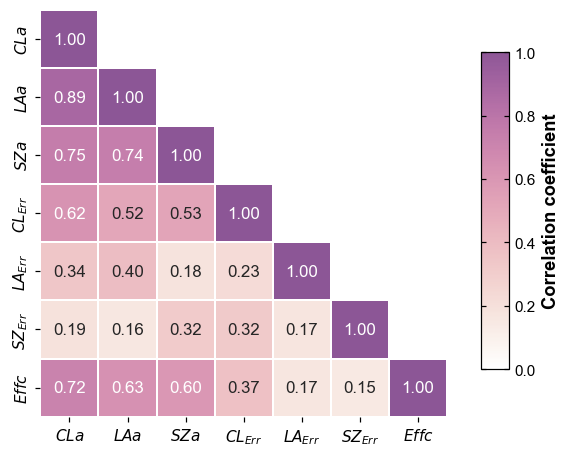

In [395]:
fig = plt.figure(dpi=110, )
ax1 = fig.add_subplot(111)
cmap = sns.cubehelix_palette(rot=0.4, hue=0.9, gamma=0.7, dark=0.3, light=1, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), 1)
g=sns.heatmap(data=corr_matrix, vmax=1, vmin=0, linewidth=1, linecolor="w", cmap=cmap,
              annot = True, fmt="0.2f", square=True, mask=mask, cbar=False,
              ax=ax1, annot_kws={'size':11, 'family':"Arial"},)

rect = [0.85, 0.2, 0.04, 0.6]   #x, y, x_width, y_height
cbar_ax = fig.add_axes(rect)
cb = g.figure.colorbar(g.collections[0], cax=cbar_ax)  #share colorbar
cb.ax.tick_params(direction='in', color="k", length=3, left=True, right=True)
cb.set_label('Correlation coefficient', font={'family':'Arial', 'size':12, 'weight': 'bold'})
labels = ['$CLa$','$LAa$','$SZa$','$CL_{Err}$','$LA_{Err}$','$SZ_{Err}$',"$Effc$"]
ax1.set_yticklabels(labels);
ax1.set_xticklabels(labels);
#fig.savefig(os.path.join(save_dir, str(time.time())+'.png'), dpi=150, bbox_inches='tight')

In [41]:
def plot_sig(xstart, xend, ystart, yend, sig, ax, vert=True):
    '''
    to draw significance markers*
    sig: list. Control the shape of these annotation
    vert: bool. whether draw vertical line.
    '''
    for i in range(len(xstart)):
        if vert[i] == True:
            x = np.ones((2)) * xstart[i]
            y = np.arange(ystart[i], yend[i]+0.1, yend[i]-ystart[i])
            ax.plot(x, y, label="$y$", linewidth=1, color="0.3")
            x = np.ones((2))*xend[i]
            y = np.arange(ystart[i], yend[i]+0.1, yend[i]-ystart[i])
            ax.plot(x, y, label="$y$", linewidth=1, color="0.3")

        x = np.arange(xstart[i], xend[i]+0.1, xend[i]-xstart[i])#draw horizontal line.
        y = yend[i] + 0*x
        ax.plot(x, y, label="$y$", linewidth=2, color="0.3")

        x0 = (xstart[i] + xend[i])/2
        y0=yend[i]
        ax.annotate(r'%s'% sig[i], xy=(x0, y0),   # %s string 
                     fontsize=10, fontweight="bold", fontfamily="Microsoft YaHei",
                    color="0.3", va="baseline", ha="center") 
    plt.show()

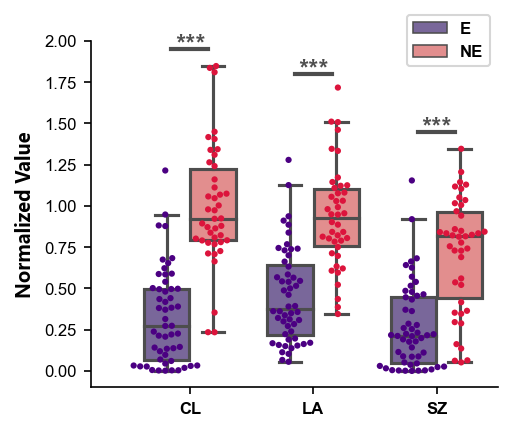

In [45]:
#boxplot
df4 = pd.read_excel(os.path.join(save_dir,'boxplot.xlsx'),
                   sheet_name="kill_adj", index_col=0)
fig = plt.figure(figsize=(3.5,3), dpi=150)
ax1 = fig.add_subplot(111)

c1 = ["#765EA3", "lightcoral"]
c2 = ["indigo", "crimson"]
a = sns.boxplot(x="Attri", y="val", hue="effc", data=df4, ax=ax1, 
                linewidth=1.5, width=0.75, showfliers=False, dodge=True, palette=c1);
b = sns.swarmplot(x="Attri", y="val", hue="effc", data=df4,  palette=c2,
                  size=3, dodge=True, ax=ax1);

handles = ax1.get_legend_handles_labels()
ax1.legend(handles = handles[0][0:2], bbox_to_anchor=(1, 1.1), 
           labels=["E","NE"], prop={"size":8, 'weight':"bold"})
plt.ylabel("Normalized Value", fontsize=9, fontweight="600", fontfamily="Microsoft YaHei")
plt.xlabel(None)
ax1.set_xticklabels(["CL","LA","SZ"], fontweight="600", fontfamily="Arial")
plt.tick_params(axis='both', direction='out', labelsize=8)
plt.ylim(-0.1,2)
plt.xlim(-0.8,2.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plot_sig([-0.15,0.85,1.85], [0.15,1.15,2.15], [1.8,1.7,1.4], [1.95,1.8,1.45], 
         ['***','***','***'], ax1, [0,0,0])
#fig.savefig(os.path.join(save_dir, str(time.time())+'.png'), dpi=200, bbox_inches='tight')

In [4]:
#PCA
pca = skldec.PCA()
pca.fit(df3)
result = pca.transform(df3)

data = pd.DataFrame(result)
data['label'] = np.array(df.effc)
data

,0,1,2,3,4,5,label
0,1.716002,0.035878,0.096184,-0.075637,0.030290,0.066523,1
1,0.693676,0.447050,-0.164975,0.000187,0.155484,0.054385,1
2,-0.382791,0.994978,0.081704,-0.052080,0.068707,-0.002045,0
3,0.644134,0.411908,0.115701,-0.068697,-0.004609,-0.032591,1
4,1.459682,-0.078248,-0.342719,0.014896,0.255272,0.043671,1
...,...,...,...,...,...,...,...
89,-0.932429,-0.016139,0.000975,-0.049787,-0.014419,0.018728,0
90,-0.917494,-0.027223,0.025770,-0.043373,0.002811,0.022065,0
91,-0.941914,-0.014663,0.013553,-0.044438,0.003312,0.022242,0
92,-0.968697,-0.001484,0.049589,-0.049317,0.004837,0.020648,0


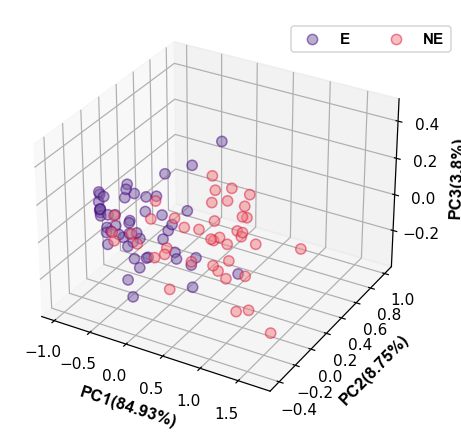

In [52]:
fig_a = plt.figure(dpi=110)
ax = fig_a.add_subplot(111, projection='3d') #3D scatter
d1 = data.loc[data['label']==0]
d2 = data.loc[data['label']==1]

ax.scatter(d1.iloc[:, 0], d1.iloc[:, 1], d1.iloc[:, 2], c="#765EA3", alpha=0.5, 
           edgecolor="indigo", s=45, label='E')
ax.scatter(d2.iloc[:, 0], d2.iloc[:, 1], d2.iloc[:, 2], c="lightcoral", alpha=0.5, 
           edgecolor="crimson", s=45, label='NE')

x_label = 'PC1(%s%%)' % round(pca.explained_variance_ratio_[0]*100.0, 2);
y_label = 'PC2(%s%%)' % round(pca.explained_variance_ratio_[1]*100.0, 2);
z_label = 'PC3(%s%%)' % round(pca.explained_variance_ratio_[2]*100.0, 2);
font1 = {'family':'Arial', 'size':11, "color":"k", 'weight':'bold',}
ax.legend(bbox_to_anchor=(1.1, 0.98), ncol=2, prop={"size":10, "weight":"bold", 'family':'Arial'})
ax.tick_params(labelsize=10, color="k")
ax.set_xlabel(x_label, font1)
ax.set_ylabel(y_label, font1)
ax.set_zlabel(z_label, font1)
plt.show()
fig_a.savefig(os.path.join(save_dir, str(time.time())+'.png'), dpi=150, )

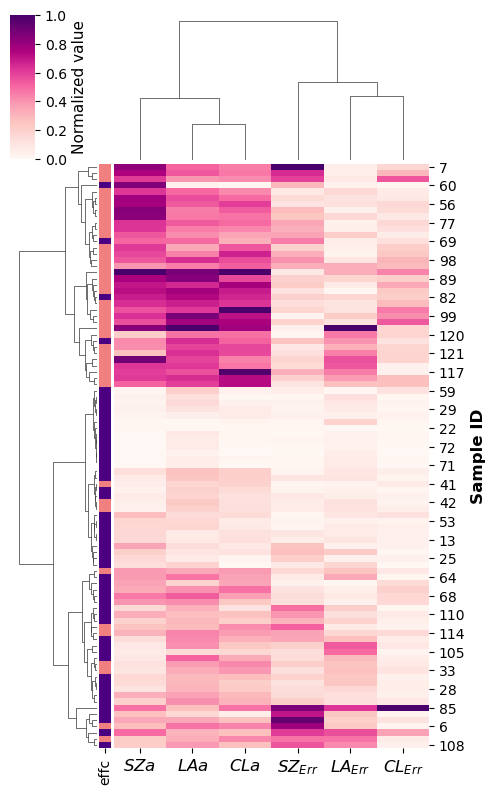

In [153]:
#clustermap
my_palette = dict(zip(df.effc.unique(), ["lightcoral", "indigo"]))#lightcoral:NE; indigo:E
row_colors = df.effc.map(my_palette)
h=sns.clustermap(df3, method ='ward', metric='euclidean', standard_scale=1, vmax=1, vmin=0,
                 cmap='RdPu', row_colors=row_colors,
                 figsize=(5, 8), dendrogram_ratio=0.2, cbar_kws={'anchor':(1,1),}
                )
h.cax.tick_params(labelsize=10, color="k", right=True)
h.cax.set_ylabel('Normalized value', fontsize=11)
h.ax_heatmap.tick_params(axis='y', labelsize=10)
h.ax_heatmap.set_ylabel('Sample ID', fontsize=12, fontweight='bold')
xlabel = ['$SZa$','$LAa$','$CLa$','$SZ_{Err}$','$LA_{Err}$','$CL_{Err}$']
h.ax_heatmap.set_xticklabels(xlabel, fontsize=12,);
#h.savefig(os.path.join(save_dir, str(time.time())+'.png'), dpi=150, )

# two type classifier

## data process & Visualization
use average to fill nan. 1-CLa as kill if kill == nan

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_train_test(dataframe, dataframe_y, test_size=0.2, random_state=42):
    split = StratifiedShuffleSplit(test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(dataframe, dataframe_y):
        train_set = dataframe.iloc[train_index]
        test_set = dataframe.iloc[test_index]
    return train_set, test_set

In [10]:
start_train_set, start_test_set = split_train_test(df, df["effc"])
start_train_set.head()

,cancer,sample_id,LAa,LAErr,SZa,SZErr,CLa,CLErr,effc,kill
id,,,,,,,,,,
80,CCom,A2,0.73102,0.02199,0.45568,0.03990,0.88166,0.10193,0,0.49000
76,BC,A6,0.88654,0.06394,0.83419,0.02892,0.78035,0.03184,1,0.21965
75,BC,A5,0.74513,0.01565,0.53963,0.04687,0.43542,0.08215,0,0.56458
31,STS,A4,0.80518,0.13636,0.53674,0.11692,0.97353,0.14199,1,0.10000
9,GCa,A1,0.13751,0.01783,0.02638,0.01450,0.13777,0.01425,0,0.33000


In [11]:
train_set_2 = start_train_set.loc[:, ["LAa","CLa","SZa","effc"]]
test_set_2 = start_test_set.loc[:, ["LAa","CLa","SZa","effc"]]

index3 = ["LAa","LAErr","SZa","SZErr","CLa","CLErr","effc"]
train_set_3 = start_train_set.loc[:, index3]
test_set_3 = start_test_set.loc[:, index3]
train_set_3.head(8)

,LAa,LAErr,SZa,SZErr,CLa,CLErr,effc
id,,,,,,,
80,0.73102,0.02199,0.45568,0.03990,0.88166,0.10193,0
76,0.88654,0.06394,0.83419,0.02892,0.78035,0.03184,1
75,0.74513,0.01565,0.53963,0.04687,0.43542,0.08215,0
31,0.80518,0.13636,0.53674,0.11692,0.97353,0.14199,1
9,0.13751,0.01783,0.02638,0.01450,0.13777,0.01425,0
33,0.60747,0.10823,0.13574,0.04558,0.72641,0.05372,1
10,0.48793,0.03798,0.17683,0.00914,0.38125,0.02639,0
4,0.58451,0.08473,0.21197,0.17402,0.20764,0.00256,0


In [12]:
def num_cat(dataframe, column="effc"):
    data_num = dataframe.drop(column, axis=1)
    list_cat = dataframe[column].tolist()
    data_cat = np.array(list_cat)
    return data_num, data_cat

In [13]:
X_train_3, y_train_3 = num_cat(train_set_3, column="effc")
X_test_3, y_test_3 = num_cat(test_set_3, column="effc")

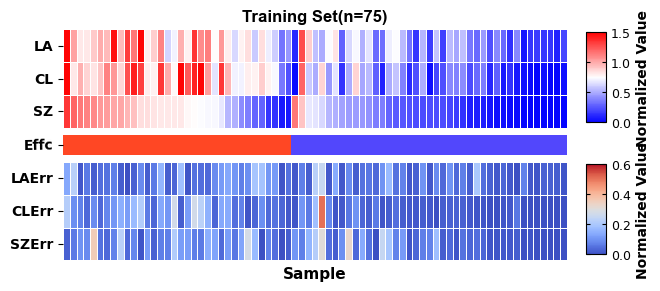

In [147]:
fig = plt.figure(dpi=100, figsize=(6.5,3))
grid = fig.add_gridspec(3, 1, hspace=0.1, height_ratios=[4,0.8,4])
ax1 = plt.subplot(grid[0,:])
ax2 = plt.subplot(grid[2,:])
ax0 = plt.subplot(grid[1,:])
############## heatmap123
data = train_set_3.sort_values(by = ['effc',"SZa"], ascending=False)
h=sns.heatmap(data=data[["LAa","CLa","SZa"]].T, 
            ax=ax1,
            vmin=0, vmax=1.5,
            linewidth=0.7,
            linecolor="w",
            cmap=sns.color_palette('bwr',n_colors=100),
            cbar=False,
            cbar_kws={ 'label':'Normalized Value', 'extend':'both',},
           )
g=sns.heatmap(data=data[["LAErr","CLErr","SZErr"]].T, 
            ax=ax2,
            linewidth=0.7,
            vmin=0, vmax=0.6,
            linecolor="w",
            cmap=sns.color_palette('coolwarm',n_colors=100),
            cbar=False
           )
sns.heatmap(data=np.array(data["effc"]).reshape(1,-1), #reshape to form 2D array
            ax=ax0,
            linewidth=0,
            linecolor="w",
            cmap=sns.color_palette('rainbow',n_colors=10),
            cbar=False
           )
ax0.set_xlabel(None) 
ax0.set_xticks([]);
ax0.set_yticklabels(["Effc"], rotation=1, fontweight="bold")
############ cbar
rect = [0.93, 0.57, 0.03, 0.3]   #x, y, width, height
cbar_ax = fig.add_axes(rect)
cb = h.figure.colorbar(h.collections[0], cax=cbar_ax)  #share colorbar
cb.ax.tick_params(direction='in', labelsize=9, color="k", length=3, left=True, right=True)
cb.ax.set_ylabel( 'Normalized Value',fontweight="bold", fontsize=10)
###################
rect2 = [0.93, 0.13, 0.03, 0.3]
cbar_ax2 = fig.add_axes(rect2)
cb2 = g.figure.colorbar(g.collections[0], cax=cbar_ax2)
cb2.ax.tick_params(direction='in', labelsize=9, color="k", length=3,
                  left=True, right=True)
cb2.ax.set_ylabel( 'Normalized Value', fontweight="bold", fontsize=10)
################### set axis
font1 = {'family': 'Arial',  #Microsoft JhengHei
         'color': 'k',
         'weight': 'bold', }
ax1.set_title("Training Set(n=%s)" % train_set_3.shape[0], font1);
ax1.set_yticklabels(["LA","CL","SZ"], fontweight="bold", rotation=0)
ax2.set_yticklabels(["LAErr","CLErr","SZErr"], fontweight="bold")
ax1.set_xlabel(None) 
ax2.set_xlabel("Sample", fontweight="bold", fontsize=11) 
ax1.set_xticks([]);
ax2.set_xticks([]);

fig.savefig(os.path.join(save_dir, str(time.time())+'.svg'), bbox_inches='tight', dpi=150)

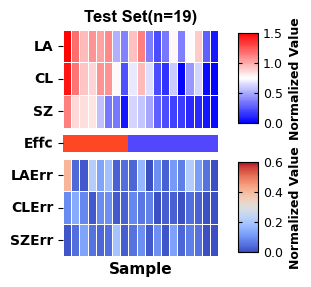

In [22]:
fig = plt.figure(dpi=100, figsize=(2,3))
grid = fig.add_gridspec(3, 1, hspace=0.1, height_ratios=[4,0.7,4])
ax1 = plt.subplot(grid[0,:])
ax2 = plt.subplot(grid[2,:])
ax0 = plt.subplot(grid[1,:])
############## heatmap123
data = test_set_3.sort_values(by = ['effc',"SZa"], ascending=False)
h=sns.heatmap(data=data[["LAa","CLa","SZa"]].T, 
            ax=ax1,
            vmin=0,vmax=1.5,
            linewidth=0.7,
            linecolor="w",
            cmap=sns.color_palette('bwr', n_colors=100),
            cbar=False,
            cbar_kws={ 'label':'Normalized Value', 'extend':'both',},
           )
g=sns.heatmap(data=data[["LAErr","CLErr","SZErr"]].T, 
            ax=ax2,
            linewidth=0.7,
            vmin=0,vmax=0.6,
            linecolor="w",
            cmap=sns.color_palette('coolwarm', n_colors=100),
            cbar=False)
sns.heatmap(data=np.array(data["effc"]).reshape(1,-1),
            ax=ax0,
            linewidth=0,
            linecolor="w",
            cmap=sns.color_palette('rainbow', n_colors=10),
            cbar=False)
ax0.set_xlabel(None) 
ax0.set_xticks([]);
ax0.set_yticklabels(["Effc"], rotation=1, fontweight="bold")
############ cbar
rect = [1, 0.57, 0.1, 0.3]
cbar_ax = fig.add_axes(rect)
cb = h.figure.colorbar(h.collections[0], cax=cbar_ax)
cb.ax.tick_params(direction='in', labelsize=9, color="k",length=3,
                  left=True, right=True)
cb.ax.set_ylabel( 'Normalized Value', fontweight="bold", fontsize=9)
###################
rect2 = [1, 0.14, 0.1, 0.3]
cbar_ax2 = fig.add_axes(rect2)
cb2 = g.figure.colorbar(g.collections[0], cax=cbar_ax2) 
cb2.ax.tick_params(direction='in', labelsize=9, color="k", length=3,
                  left=True, right=True) 
cb2.ax.set_ylabel( 'Normalized Value', fontweight="bold", fontsize=9)
################### set axis
font1 = {'family':'Arial', 'color':'k', 'weight':'bold',}
ax1.set_title("Test Set (n=%s)" % test_set_3.shape[0], font1);
ax1.set_yticklabels(["LA","CL","SZ"], fontweight="bold", rotation=0)
ax2.set_yticklabels(["LAErr","CLErr","SZErr"], fontweight="bold")
ax1.set_xlabel(None) 
ax2.set_xlabel("Sample", fontweight="bold", fontsize=11) 
ax1.set_xticks([]);
ax2.set_xticks([]);
fig.savefig(os.path.join(save_dir, str(time.time())+'.svg'), bbox_inches='tight', dpi=150)

## Model Training
3 algorithms: SGD, RF, SVM. mulitmode (=3) data

### without parameter tuning

#### SGD

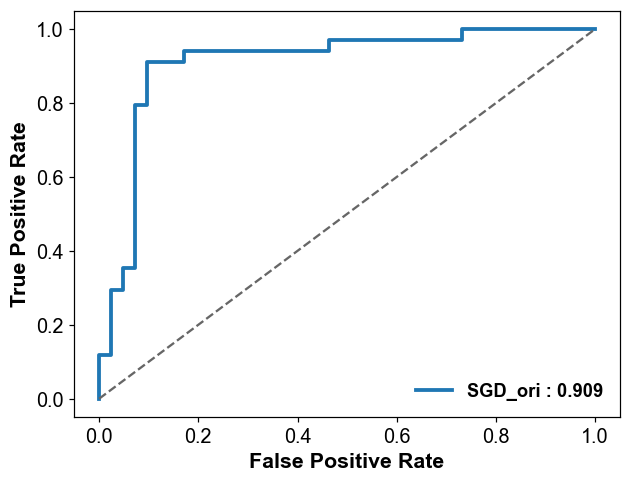

In [403]:
sgd_clf3 = SGDClassifier(random_state=42)
r_s = ML_result(sgd_clf3, X_train_3, y_train_3, "SGD_ori", roc="sgd", feedback=1, save_dir=save_dir,)

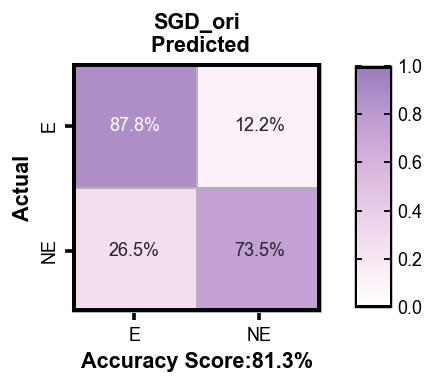

In [398]:
conf_mat_heatmap(r_s["conf_mat"], rect_set=rect_set, title="SGD_ori", save_dir=save_dir)

#### RF

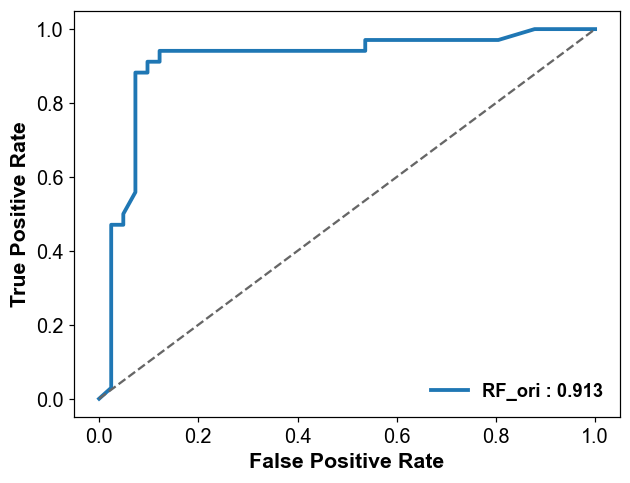

In [399]:
forest_clf3 = RandomForestClassifier(random_state=42)
r_f = ML_result(forest_clf3, X_train_3, y_train_3, "RF_ori", roc="rf", feedback=1, save_dir=save_dir)

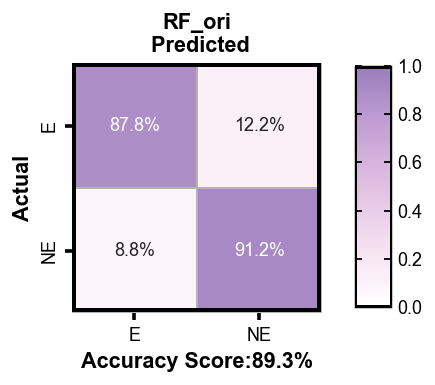

In [317]:
conf_mat_heatmap(r_f["conf_mat"], rect_set=rect_set, title="RF_ori", save_dir=save_dir)

#### SVM

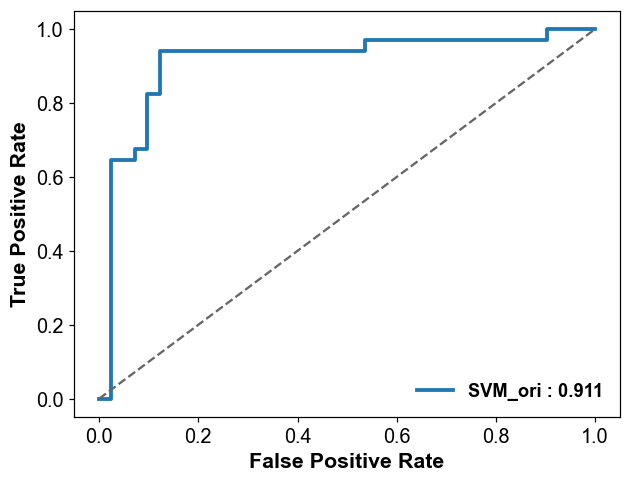

In [400]:
svc3 = SVC(probability=True, random_state=42)
r_v = ML_result(svc3, X_train_3, y_train_3, "SVM_ori", roc="rf", feedback=1, save_dir=save_dir)

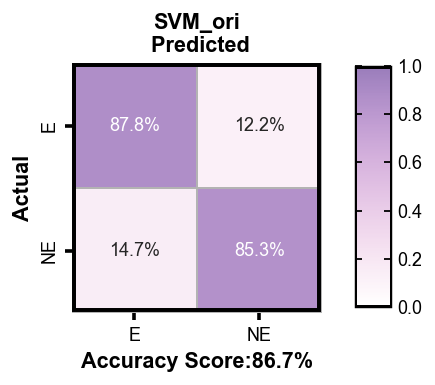

In [320]:
conf_mat_heatmap(r_v["conf_mat"], rect_set=rect_set, title="SVM_ori", save_dir=save_dir)

#### re-paint

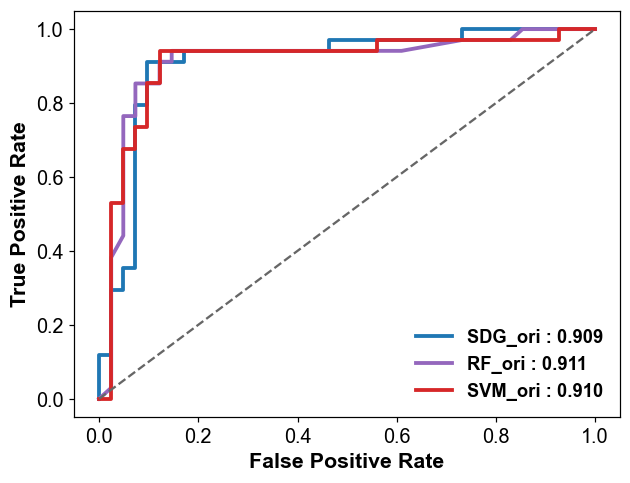

In [337]:
plot_roc_curve([r_s["fpr"], r_f["fpr"], r_v["fpr"]], 
               [r_s["tpr"], r_f["tpr"], r_v["tpr"]], 
               ["SDG_ori", "RF_ori", "SVM_ori"],
               [r_s["auc"], r_f["auc"], r_v["auc"]], save_dir=save_dir,
               cmap=[plt.get_cmap('tab10')(0),plt.get_cmap('tab10')(4),plt.get_cmap('tab10')(3)], )

### GridSearch
triple modal data

#### SGD
best_SGDClassifier(alpha=0.055564444444444444, eta0=0.26126315789473686,  
              learning_rate='invscaling', loss='log', n_jobs=-1, penalty='l1',  
              power_t=0.07357142857142857, random_state=42)

In [976]:
#trainable parameters
sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': -1,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Run Time:1806.9934689998627 s
[{'alpha': 0.055564444444444444, 'class_weight': None, 'eta0': 0.26126315789473686, 'learning_rate': 'invscaling', 'loss': 'log', 'penalty': 'l1', 'power_t': 0.07357142857142857}, SGDClassifier(alpha=0.055564444444444444, eta0=0.26126315789473686,
              learning_rate='invscaling', loss='log', n_jobs=-1, penalty='l1',
              power_t=0.07357142857142857, random_state=42)]


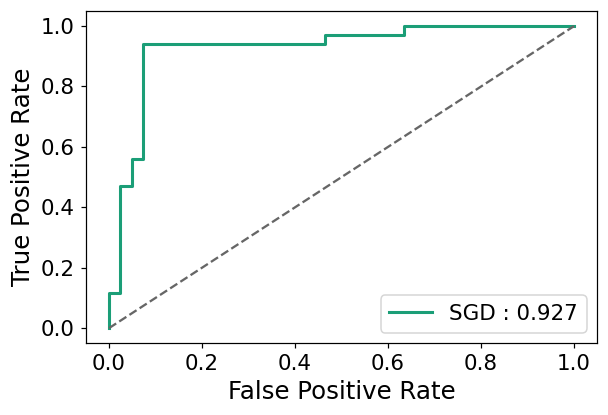

{'conf_mat': array([[38,  3],
        [ 2, 32]], dtype=int64),
 'accu': 0.9333333333333333,
 'auc': 0.9268292682926829}

In [27]:
param=[{"learning_rate": ['constant','optimal','invscaling'], 
        'penalty': ['l2','l1','elasticnet'], 
        "eta0":np.linspace(0.01,0.5,num=10), 
        "loss":["hinge","modified_huber","log"], 
        "alpha":np.linspace(0.0001,0.09,num=10),
        "power_t":np.linspace(0.001,0.1,num=10), 
        "class_weight":[None,"balanced"],
        "l1_ratio":np.linspace(0.1,0.9,num=10)
       }]

sgdbest = GridSearch_result(sgd_clf, X_train_3, y_train_3, param)
print(sgdbest)

Re_best_sgd = ML_result(sgdbest[1], X_train_3, y_train_3, "SGD", roc="sgd", feedback=1, save_dir=save_dir)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


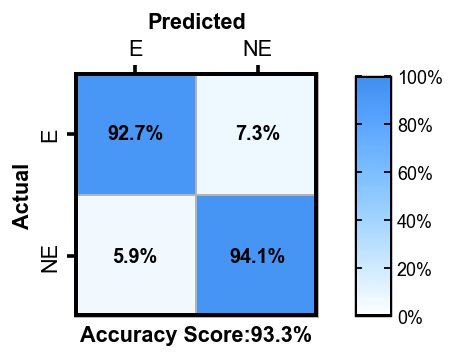

In [62]:
conf_mat_heatmap(Re_best_sgd['conf_mat'], rect_set=rect_set, title="SGD", save_dir=save_dir)

#### RF
best_RandomForestClassifier(max_depth=2, max_features=3, min_samples_leaf=6,  
                       n_estimators=3, n_jobs=-1, random_state=42)

In [980]:
#trainable parameters
forest_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Run Time:2376.3678488731384 s
[{'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 3}, RandomForestClassifier(max_depth=2, max_features=3, min_samples_leaf=6,
                       n_estimators=3, n_jobs=-1, random_state=42)]


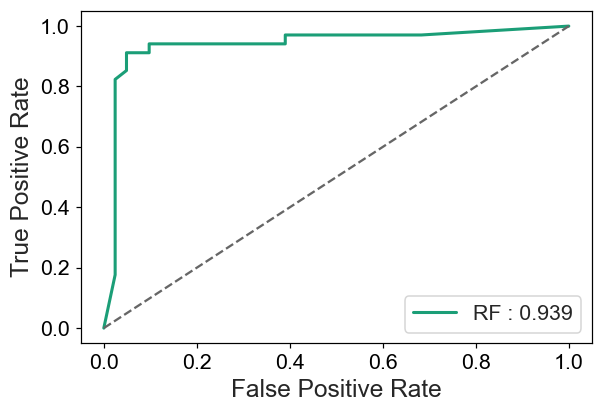

{'conf_mat': array([[38,  3],
        [ 3, 31]], dtype=int64),
 'accu': 0.92,
 'auc': 0.9390243902439024}

In [66]:
param2 = [{'n_estimators': range(2,18), 
           "max_depth":[None, 2, 3, 5], 
           "max_features":["auto", 6, 5, 4, 3],
           "min_samples_split":[2, 3, 4, 6], 
           "min_samples_leaf":[6, 8, 10, 5]
          }]
rfbest = GridSearch_result(forest_clf, X_train_3, y_train_3, param2, score="roc_auc")
print(rfbest)
ML_result(rfbest[1], X_train_3, y_train_3, "RF", roc="rf", feedback=1, save_dir=save_dir)

          0      1
0  0.433293    CLa
1  0.275099    SZa
2  0.222177    LAa
3  0.066863  LAErr
4  0.002568  SZErr
5  0.000000  CLErr


<BarContainer object of 6 artists>

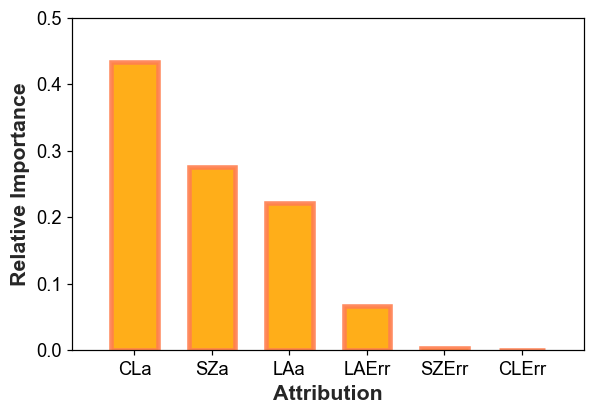

In [219]:
#feature importance. sum=100
rf_impo = rfbest[1].feature_importances_
impo_df = pd.DataFrame(sorted(zip(rf_impo, X_train_3.columns), reverse=True))
print(impo_df)

plt.rcParams['axes.labelsize'] = 14 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
sns.set_style("ticks", {"axes.edgecolor": "k", 'xtick.color': 'k',
                 'ytick.color': 'k',})
fig, ax1 = plt.subplots(dpi=110,)
ax1.set_ylabel('Relative Importance', fontweight="bold")
ax1.set_xlabel('Attribution', fontweight="bold")
ax1.set_xlim(-0.8, 5.8)
ax1.set_ylim(0, 0.5)
ax1.bar(x=impo_df[1], height=impo_df[0], width=0.6,
        color='orange',alpha=0.9, edgecolor='coral', linewidth=3, )

[[10  1]
 [ 2  6]]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


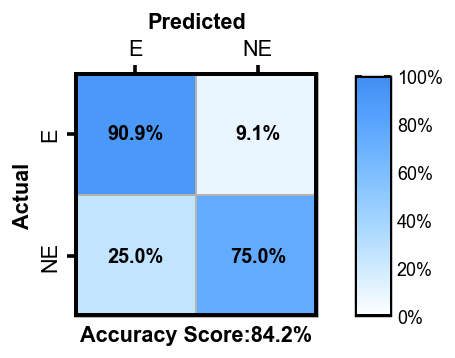

In [322]:
# test set
final_pred_rf=rfbest[1].predict(X_test)
confmatrf = confusion_matrix(y_test, final_pred_rf)
print(confmatrf)
conf_mat_heatmap(confmatrf, "testrf", save=0, )

#### SVM
the best: SVC(class_weight='balanced', degree=1, gamma='auto', kernel='linear',
    probability=True, random_state=42)

In [347]:
#trainable parameters
svc_clf = SVC(probability=True, random_state=42)
svc_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Run Time:19.477946281433105 s
[{'C': 1.0, 'class_weight': 'balanced', 'degree': 1, 'gamma': 'auto', 'kernel': 'linear'}, SVC(class_weight='balanced', degree=1, gamma='auto', kernel='linear',
    probability=True, random_state=42)]


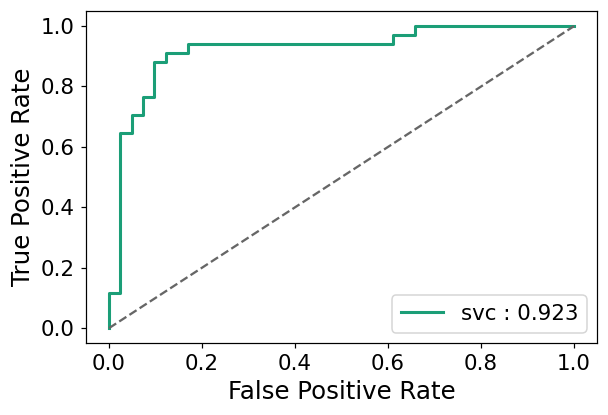

{'conf_mat': array([[36,  5],
        [ 3, 31]], dtype=int64),
 'accu': 0.8933333333333333,
 'auc': 0.9225251076040172}

In [30]:
param3 = [{'kernel':["rbf", "poly", "linear"], 
           "C":[0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3], 
           "degree":[1,2,3,4,5],
           "gamma":["auto", 1/5, 1/6, 1/7, 1/8, 1/9, 1/10, 1/11], 
           "class_weight":[None, "balanced"],
          }]
svcbest = GridSearch_result(svc_clf, X_train_3, y_train_3, param3,)
print(svcbest)
ML_result(svcbest[1], X_train_3, y_train_3, "SVM", roc="rf", feedback=1, save_dir=save_dir)

#### re-paint

In [ ]:
import rpy2.robjects as robj  # try to use R in Python

In [39]:
def repaint_y_score(ML, X, y, roc):
    ML.fit(X, y)
    y_pred = cross_val_predict(ML, X, y, cv=3)
    conf_mat=confusion_matrix(y, y_pred)
    accu=accuracy_score(y, y_pred)
    
    if roc =="rf":
        y_probas_forest = cross_val_predict(ML, X, y, cv=3, method="predict_proba")
        y_scores = y_probas_forest[:, 1] # score = proba of positive class
    if roc == "sgd":
        y_scores = cross_val_predict(ML, X, y, cv=3, method="decision_function")  
    return {"conf_mat":conf_mat, "accu":accu, "y_scores":y_scores}

def roc_with_CI(y, y_scores):  #draw ROC with CI
    robj.r.source(os.path.join(save_dir,'pROC\draw_roc_ci.R'))
    y_r = robj.FloatVector(y)
    for i in range(len(y_scores)):        
        y_scores_r = robj.FloatVector(y_scores[i])
        score_list <- list(a1,b1,c1)
    robj.r.draw_roc_ci(y_r, y_scores_r)


In [50]:
a1=robj.FloatVector(sgd2['y_scores'])
b1=robj.FloatVector(rf2['y_scores'])
c1=robj.FloatVector(svm2['y_scores'])
score_list <- list(a1,b1,c1)
y1=robj.FloatVector(y_train)

0.731924,0.764130,0.340754,0.821386,...,0.046913,0.258882,0.473885,0.119770


In [53]:
sgd1 = SGDClassifier(alpha=0.0556, eta0=0.261, learning_rate='invscaling', loss='log',
                     n_jobs=-1, penalty='l1', power_t=0.0736, random_state=42)
sgd2 = repaint_y_score(sgd1, X_train, y_train, roc="sgd")
rf1 =  RandomForestClassifier(max_depth=2, max_features=3, min_samples_leaf=6, 
                              n_estimators=3, n_jobs=-1, random_state=42)
rf2 = repaint_y_score(rf1, X_train, y_train, roc="rf")
svm1 = SVC(class_weight='balanced', degree=1, gamma='auto', kernel='linear', 
           probability=True, random_state=42)
svm2 = repaint_y_score(svm1, X_train, y_train, roc="rf")
print(sgd2)
print(rf2)
print(svm2)

{'conf_mat': array([[38,  3],
       [ 2, 32]], dtype=int64), 'accu': 0.9333333333333333, 'y_scores': array([ 0.72312367,  0.39980977, -0.70097657,  1.01631139, -1.6508767 ,
        0.22766929, -0.87385105, -1.42789829, -0.50978383, -2.07784508,
        1.7860608 ,  0.66615838, -1.89814115,  0.71511343, -0.75554835,
       -1.34268972, -0.8452248 , -1.22071699, -1.99413643, -0.50116724,
       -1.25784696,  0.02785996,  1.03386372, -0.04932988,  2.39464792,
       -0.35010662, -1.48451378,  0.38752314,  0.85253221, -0.25019795,
        1.61050879,  1.26859713, -1.49846388,  0.92760207,  1.44594676,
       -1.23269654, -1.55030729,  0.02397522,  0.80580694, -0.94629467,
       -0.43557335, -1.02550174, -0.7015419 , -1.4032276 ,  1.43682554,
        0.3152954 ,  0.0334765 ,  0.24907712, -1.51670632, -0.59102003,
       -1.54509993,  0.68436951,  0.08870872, -1.29385309,  0.36073329,
       -0.98084116,  2.67070193,  0.82453423, -1.83546116,  0.40051707,
       -1.25106773,  2.85025618,  

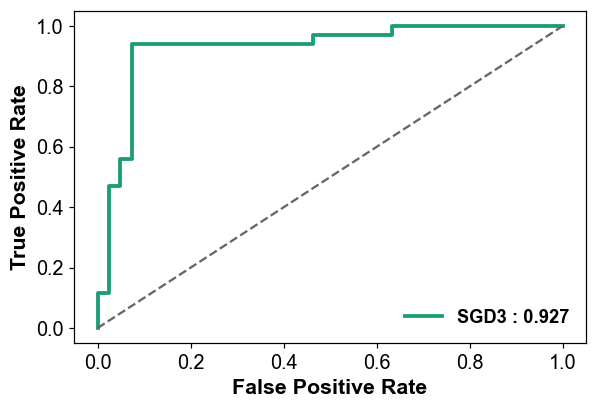

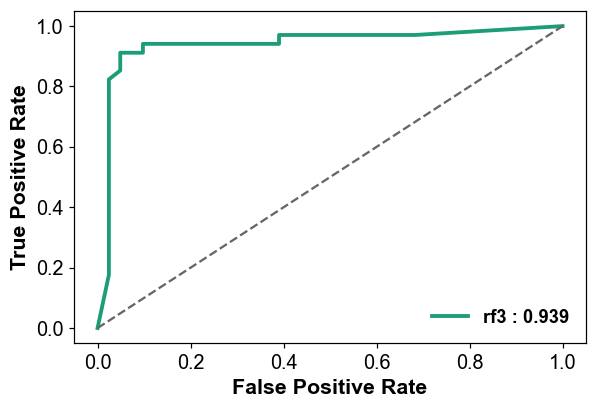

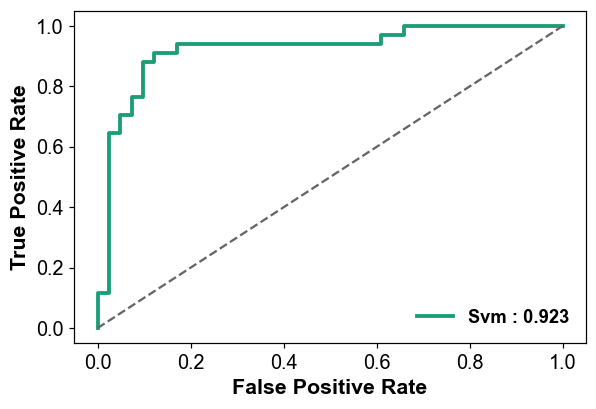

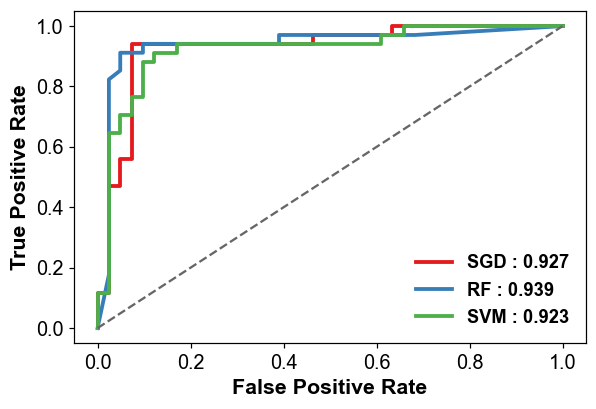

In [32]:
sgd1 = SGDClassifier(alpha=0.0556, eta0=0.261, learning_rate='invscaling', loss='log',
                     n_jobs=-1, penalty='l1', power_t=0.0736, random_state=42)
sgd2 = ML_result(sgd1, X_train, y_train, "SGD3",roc="sgd",feedback=1)
rf1 =  RandomForestClassifier(max_depth=2, max_features=3, min_samples_leaf=6, n_estimators=3, n_jobs=-1, random_state=42)
rf2 = ML_result(rf1, X_train, y_train, "rf3",roc="rf",feedback=1)
svm1 = SVC(class_weight='balanced', degree=1, gamma='auto', kernel='linear', probability=True, random_state=42)
svm2 = ML_result(svm1, X_train, y_train, "Svm",roc="rf",feedback=1)
plot_roc_curve([sgd2["fpr"],rf2["fpr"],svm2["fpr"]], [sgd2["tpr"],rf2["tpr"],svm2["tpr"]],
               label=["SGD","RF","SVM"], auc=[sgd2["auc"],rf2["auc"],svm2["auc"]], cmap=sns.color_palette("Set1"))

## single mode data

### LA
#### RF
best_RandomForestClassifier(n_estimators=16, n_jobs=-1, random_state=42)

Run Time:32.22870898246765 s
[{'max_depth': None, 'max_features': 'auto', 'n_estimators': 16}, RandomForestClassifier(n_estimators=16, n_jobs=-1, random_state=42)]


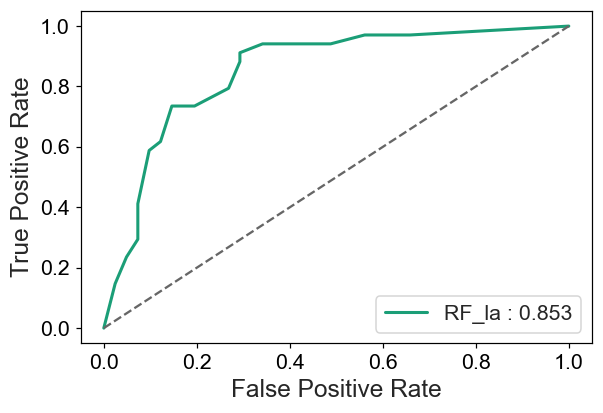

{'conf_mat': array([[35,  6],
        [ 9, 25]], dtype=int64),
 'accu': 0.8,
 'auc': 0.8525824964131994}

In [67]:
forest_la = RandomForestClassifier(random_state=42, n_jobs=-1)
param2 = [{'n_estimators': range(2,20), "max_depth":[None], "max_features":["auto",1,2],
          }]
rfbest_la = GridSearch_result(forest_la, X_train_3[["LAa","LAErr"]], y_train_3, param2,)
print(rfbest_la)
ML_result(rfbest_la[1], X_train_3[["LAa","LAErr"]], y_train_3,"RF_la", roc="rf")

#### SGD
best_SGDClassifier(eta0=0.07003000000000001, learning_rate='constant',
              loss='modified_huber', n_jobs=-1, random_state=42)

Run Time:13.13786268234253 s
[{'class_weight': None, 'eta0': 0.07003000000000001, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l2'}, SGDClassifier(eta0=0.07003000000000001, learning_rate='constant',
              loss='modified_huber', n_jobs=-1, random_state=42)]


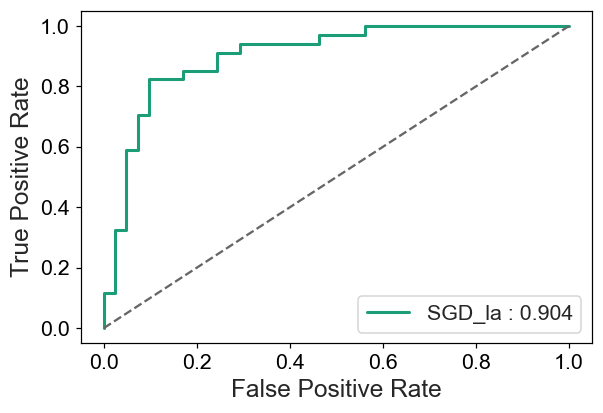

{'conf_mat': array([[37,  4],
        [ 7, 27]], dtype=int64),
 'accu': 0.8533333333333334,
 'auc': 0.9038737446197992}

In [83]:
sgd_clf_la = SGDClassifier(random_state=42,n_jobs=-1)
param=[{"learning_rate": ['constant','optimal','invscaling'], 'penalty': ['l2','l1','elasticnet'], 
        "eta0":np.linspace(0.0001,0.1,num=21), "loss":["hinge","modified_huber","log"], 
         "class_weight":[None,"balanced"]   }]
sgdbest_la = GridSearch_result(sgd_clf_la, X_train_3[["LAa","LAErr"]], y_train_3, param, )
print(sgdbest_la)
ML_result(sgdbest_la[1], X_train_3[["LAa","LAErr"]], y_train_3, "SGD_la",roc="sgd")

### CL
#### RF
best_RandomForestClassifier(max_features=2, n_estimators=10, n_jobs=-1, random_state=42)

Run Time:31.991867065429688 s
[{'max_depth': None, 'max_features': 2, 'n_estimators': 10}, RandomForestClassifier(max_features=2, n_estimators=10, n_jobs=-1,
                       random_state=42)]


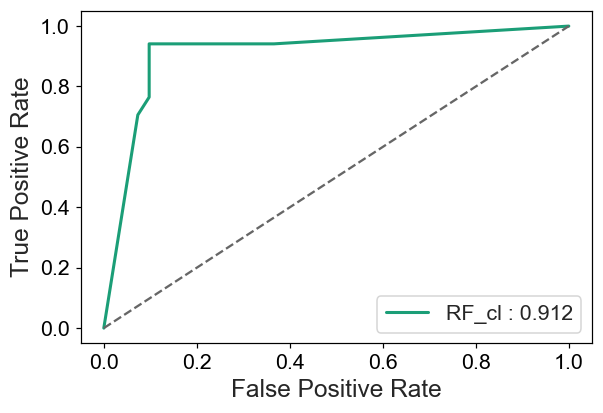

{'conf_mat': array([[37,  4],
        [ 2, 32]], dtype=int64),
 'accu': 0.92,
 'auc': 0.9117647058823529}

In [70]:
forest_cl = RandomForestClassifier(random_state=42, n_jobs=-1)
param2 = [{'n_estimators': range(2,20), "max_depth":[None], "max_features":["auto",1,2],
          }]
rfbest_cl = GridSearch_result(forest_cl, X_train_3[["CLa","CLErr"]], y_train_3, param2,)
print(rfbest_cl)
ML_result(rfbest_cl[1], X_train_3[["CLa","CLErr"]], y_train_3, "RF_cl", roc="rf")

#### SGD
best_SGDClassifier(class_weight='balanced', eta0=0.025750000000000002, 
              learning_rate='constant', loss='modified_huber', n_jobs=-1,
              random_state=42)]

Run Time:13.701422929763794 s
[{'class_weight': 'balanced', 'eta0': 0.025750000000000002, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l2'}, SGDClassifier(class_weight='balanced', eta0=0.025750000000000002,
              learning_rate='constant', loss='modified_huber', n_jobs=-1,
              random_state=42)]


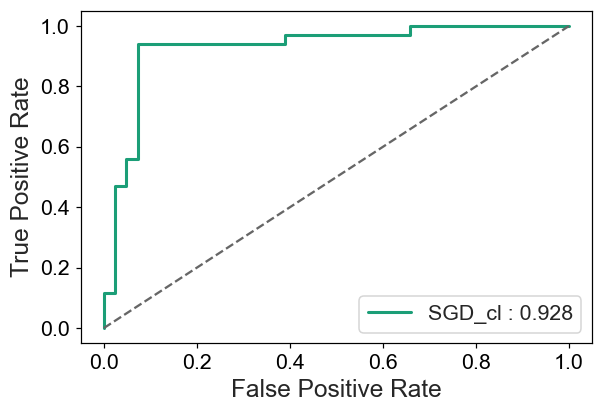

{'conf_mat': array([[38,  3],
        [ 2, 32]], dtype=int64),
 'accu': 0.9333333333333333,
 'auc': 0.9282639885222381}

In [84]:
sgd_clf_cl = SGDClassifier(random_state=42,n_jobs=-1)
param=[{"learning_rate": ['constant','optimal','invscaling'], 'penalty': ['l2','l1','elasticnet'], 
        "eta0":np.linspace(0.001,0.1,num=21), "loss":["hinge","modified_huber","log"], 
         "class_weight":[None,"balanced"]   }]
sgdbest_cl = GridSearch_result(sgd_clf_cl, X_train_3[["CLa","CLErr"]], y_train_3, param, )
print(sgdbest_cl)
ML_result(sgdbest_cl[1], X_train_3[["CLa","CLErr"]], y_train_3, "SGD_cl",roc="sgd")

### SZ
#### RF
best_RandomForestClassifier(n_estimators=18, n_jobs=-1, random_state=42)

Run Time:26.405242681503296 s
[{'max_depth': None, 'max_features': 'auto', 'n_estimators': 18}, RandomForestClassifier(n_estimators=18, n_jobs=-1, random_state=42)]


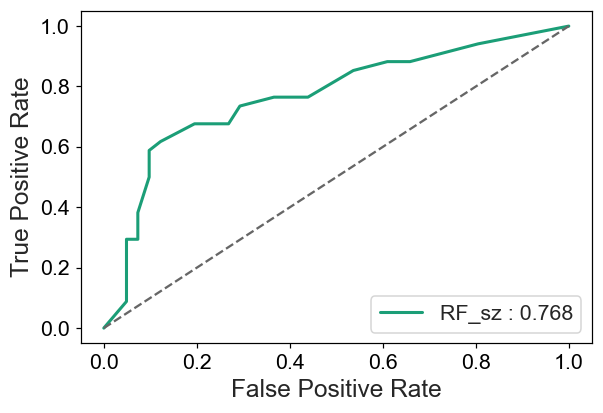

{'conf_mat': array([[36,  5],
        [13, 21]], dtype=int64),
 'accu': 0.76,
 'auc': 0.7679340028694405}

In [93]:
forest_sz = RandomForestClassifier(random_state=42, n_jobs=-1)
param2 = [{'n_estimators': range(2,20), "max_depth":[None], "max_features":["auto",1,2],
          }]
rfbest_sz = GridSearch_result(forest_sz, X_train_3[["SZa","SZErr"]], y_train_3, param2,)
print(rfbest_sz)
ML_result(rfbest_sz[1], X_train_3[["SZa","SZErr"]], y_train_3, "RF_sz", roc="rf")

#### SGD
best_SGDClassifier(eta0=0.27999999999999997, learning_rate='constant', n_jobs=-1,  
              penalty='l1', random_state=42)

Run Time:14.237128734588623 s
[{'class_weight': None, 'eta0': 0.27999999999999997, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'l1'}, SGDClassifier(eta0=0.27999999999999997, learning_rate='constant', n_jobs=-1,
              penalty='l1', random_state=42)]


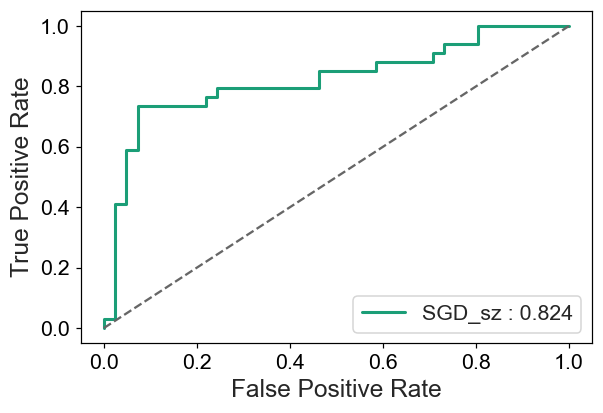

{'conf_mat': array([[37,  4],
        [ 9, 25]], dtype=int64),
 'accu': 0.8266666666666667,
 'auc': 0.8235294117647058}

In [85]:
sgd_clf_sz= SGDClassifier(random_state=42,n_jobs=-1)
param=[{"learning_rate": ['constant','optimal','invscaling'], 'penalty': ['l2','l1','elasticnet'], 
        "eta0":np.linspace(0.25,0.35,num=21), "loss":["hinge","modified_huber","log"], 
         "class_weight":[None,"balanced"]   }]
sgdbest_sz = GridSearch_result(sgd_clf_sz, X_train_3[["SZa","SZErr"]], y_train_3, param, )
print(sgdbest_sz)
ML_result(sgdbest_sz[1], X_train_3[["SZa","SZErr"]], y_train_3, "SGD_sz", roc="sgd")

#### re-paint

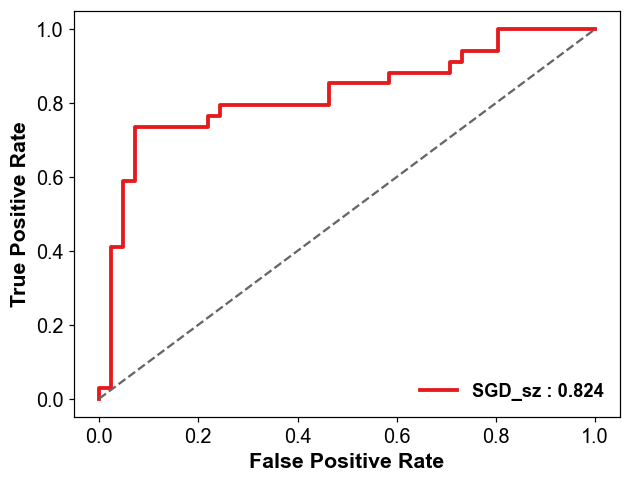

{'conf_mat': array([[37,  4],
        [ 9, 25]], dtype=int64),
 'accu': 0.8266666666666667,
 'auc': 0.8235294117647058}

In [28]:
### SGD re-draw ROC
sgd_clf4 = SGDClassifier(eta0=0.27999999999999997, learning_rate='constant', n_jobs=-1,
              penalty='l1', random_state=42)  
ML_result(sgd_clf4, X_train_3[["SZa","SZErr"]], y_train_3, "SGD_sz", roc="sgd",
          save_dir=save_dir, cmap=[sns.color_palette('Set1')[0]],)

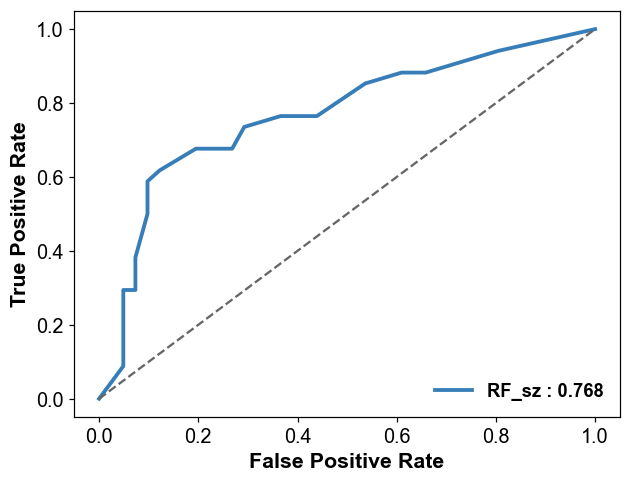

{'conf_mat': array([[36,  5],
        [13, 21]], dtype=int64),
 'accu': 0.76,
 'auc': 0.7679340028694405}

In [29]:
### RF re-draw ROC
rfbest = RandomForestClassifier(n_estimators=18, n_jobs=-1, random_state=42)
ML_result(rfbest, X_train_3[["SZa","SZErr"]], y_train_3, "RF_sz", roc="rf",
          save_dir=save_dir, cmap=[sns.color_palette('Set1')[1]],)

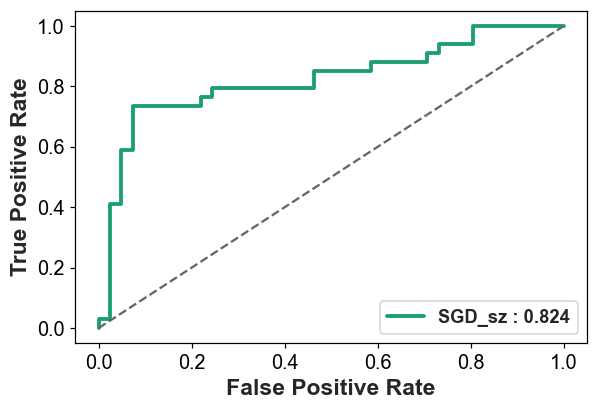

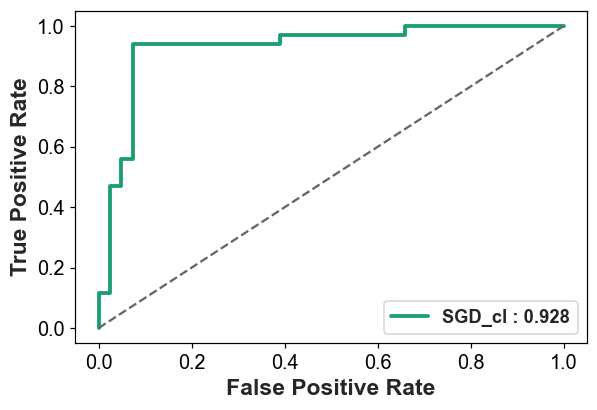

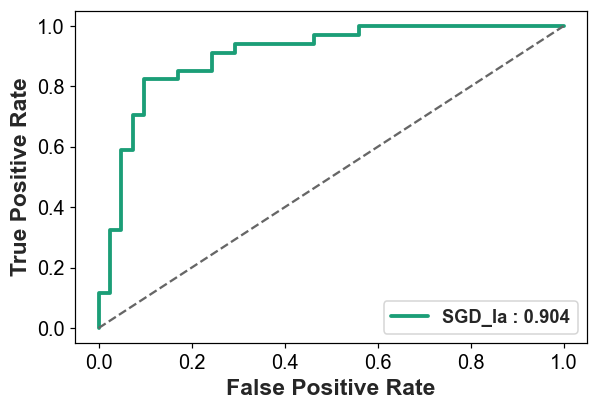

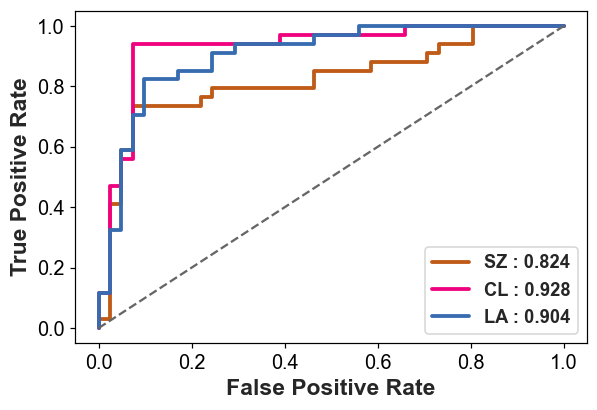

In [307]:
#re-draw
sz1 = SGDClassifier(eta0=0.28, learning_rate='constant', n_jobs=-1, penalty='l1', random_state=42)
sz2 = ML_result(sz1, X_train[["SZa","SZErr"]], y_train, "SGD_sz",roc="sgd",feedback=1)
cl1 = SGDClassifier(class_weight='balanced', eta0=0.02575, learning_rate='constant', loss='modified_huber', n_jobs=-1, random_state=42)
cl2 = ML_result(cl1, X_train[["CLa","CLErr"]], y_train, "SGD_cl",roc="sgd",feedback=1)
la1 = SGDClassifier(eta0=0.07, learning_rate='constant', loss='modified_huber', n_jobs=-1, random_state=42)
la2 = ML_result(la1, X_train[["LAa","LAErr"]], y_train, "SGD_la",roc="sgd",feedback=1)
plot_roc_curve([sz2["fpr"],cl2["fpr"],la2["fpr"]], [sz2["tpr"],cl2["tpr"],la2["tpr"]],
               label=["SZ","CL","LA"], auc=[sz2["auc"],cl2["auc"],la2["auc"]], cmap=sns.color_palette("Set1"))

## double mode data
### LA+SZ

#### SGD
best_SGDClassifier(eta0=0.15000000000000002, learning_rate='constant', loss='log',
              n_jobs=-1, random_state=42)

Run Time:12.960336446762085 s
[{'class_weight': None, 'eta0': 0.15000000000000002, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'l2'}, SGDClassifier(eta0=0.15000000000000002, learning_rate='constant', loss='log',
              n_jobs=-1, random_state=42)]


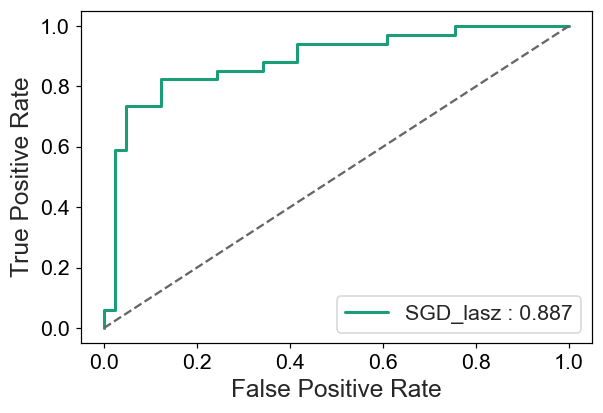

{'conf_mat': array([[36,  5],
        [ 6, 28]], dtype=int64),
 'accu': 0.8533333333333334,
 'auc': 0.8873744619799139}

In [86]:
index4 = ["LAa","LAErr","SZa","SZErr"]
sgd_clf_lasz = SGDClassifier(random_state=42, n_jobs=-1)

param=[{"learning_rate": ['constant','optimal','invscaling'], 'penalty': ['l2','l1','elasticnet'], 
        "eta0":np.linspace(0.1,0.2,num=21), "loss":["hinge","modified_huber","log"], 
        "class_weight":[None,"balanced"]  }]
sgdbest_lasz = GridSearch_result(sgd_clf_lasz, X_train_3[index4], y_train_3, param, )
print(sgdbest_lasz)
ML_result(sgdbest_lasz[1], X_train_3[index4], y_train_3, "SGD_lasz", roc="sgd")

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


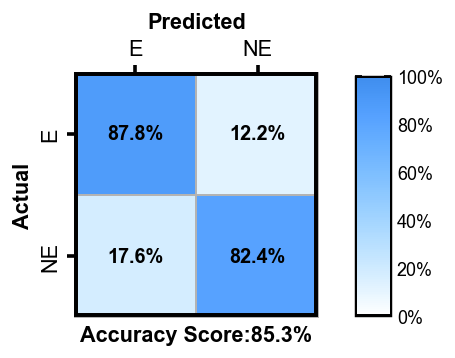

In [278]:
conf_mat_heatmap(np.array([[36,  5],  [ 6, 28]]), label="sgd_2a", save=0, )

#### RF
best_RandomForestClassifier(max_features=3, n_estimators=10, n_jobs=-1,
                       random_state=42)]

Run Time:35.15780067443848 s
[{'max_depth': None, 'max_features': 3, 'n_estimators': 10}, RandomForestClassifier(max_features=3, n_estimators=10, n_jobs=-1,
                       random_state=42)]


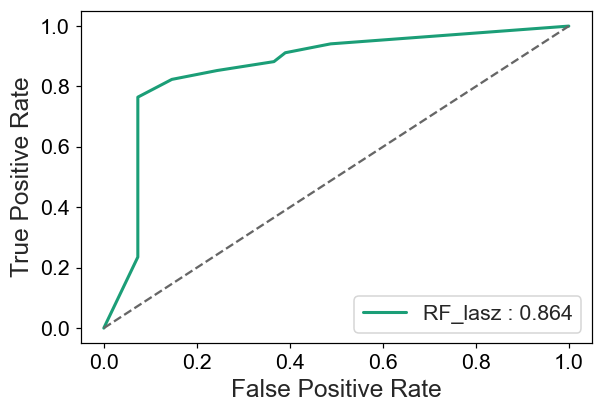

{'conf_mat': array([[38,  3],
        [ 8, 26]], dtype=int64),
 'accu': 0.8533333333333334,
 'auc': 0.8637015781922526}

In [87]:
forest_clf_lasz = RandomForestClassifier(random_state=42, n_jobs=-1)
param2 = [{'n_estimators': range(2,20), "max_depth":[None], "max_features":["auto",4,3,2],
          }]
rfbest_lasz = GridSearch_result(forest_clf_lasz, X_train_3[index4], y_train_3, param2,)
print(rfbest_lasz)
ML_result(rfbest_lasz[1], X_train_3[index4], y_train_3,"RF_lasz", roc="rf")

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


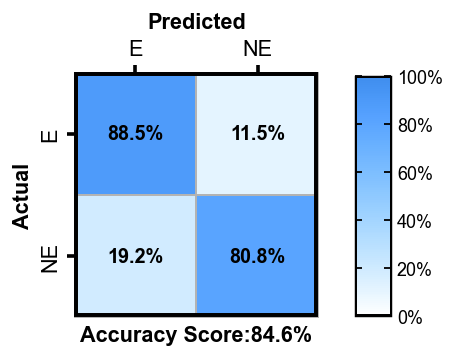

In [26]:
conf_mat_heatmap(np.array([[23,  3], [ 5, 21]]), label="rf_2a", save=0, )

#### SVM
best_SVC(C=0.8, coef0=0.7, gamma=0.1111111111111111, kernel='poly', probability=True,
    random_state=42)

Run Time:36.057945251464844 s
[{'C': 0.8, 'class_weight': None, 'coef0': 0.7, 'degree': 3, 'gamma': 0.1111111111111111, 'kernel': 'poly'}, SVC(C=0.8, coef0=0.7, gamma=0.1111111111111111, kernel='poly', probability=True,
    random_state=42)]


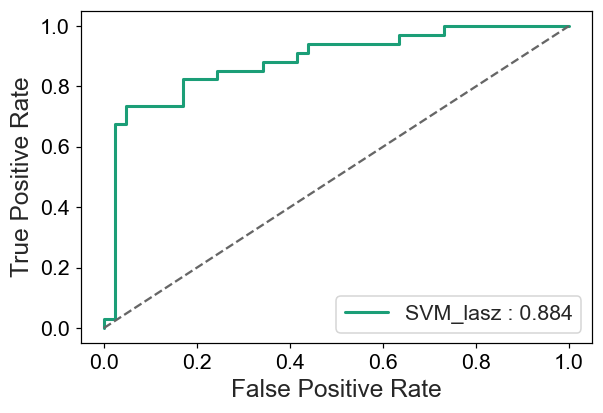

{'conf_mat': array([[39,  2],
        [ 9, 25]], dtype=int64),
 'accu': 0.8533333333333334,
 'auc': 0.8837876614060258}

In [78]:
svc_lasz = SVC(probability=True,random_state=42)
param3 = [{'C':[0.8,0.9,1, 0.7], "class_weight":[None,"balanced"], 
           "kernel":['linear',"poly","rbf",],"degree":[1,2,3],"coef0":[0.1,0.4,0.7,1.0]
           "gamma":["auto",1/10,1/9,1/11], }]
svcbest_lasz = GridSearch_result(svc_lasz, X_train_3[index4], y_train_3, param3,)
print(svcbest_lasz)
ML_result(svcbest_lasz[1], X_train_3[index4], y_train_3, "SVM_lasz", roc="rf")

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


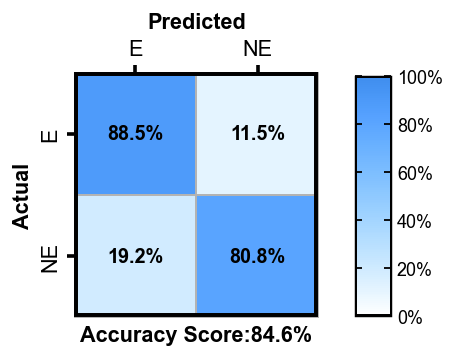

In [20]:
conf_mat_heatmap(np.array([[23,  3],[ 5, 21]]), label="svm_2a", save=0, )

### LA+CL
#### RF
best_RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)]

Run Time:43.674476861953735 s
[{'max_depth': None, 'max_features': 'auto', 'n_estimators': 10}, RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)]


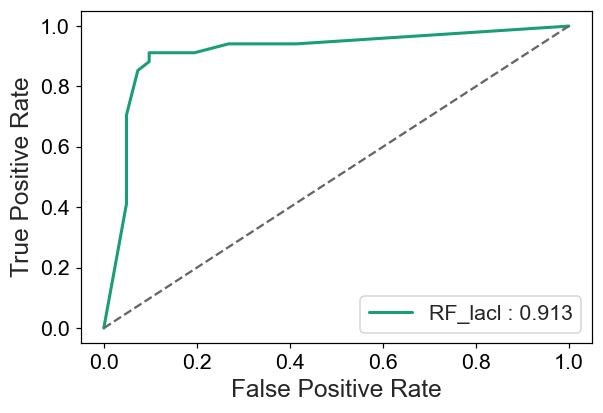

{'conf_mat': array([[37,  4],
        [ 3, 31]], dtype=int64),
 'accu': 0.9066666666666666,
 'auc': 0.9128407460545194}

In [79]:
index6=["LAa","LAErr","CLa","CLErr"]
forest_clf_lacl = RandomForestClassifier(n_jobs=-1,random_state=42)
param2 = [{'n_estimators': range(2,20), "max_depth":[None], 
           "max_features":["auto",3,4,2], }]
rfbest_lacl = GridSearch_result(forest_clf_lacl, X_train_3[index6], y_train_3, param2,)
print(rfbest_lacl)
ML_result(rfbest_lacl[1], X_train_3[index6], y_train_3,"RF_lacl", roc="rf")

#### SDG
best_SGDClassifier(eta0=0.9, learning_rate='constant', n_jobs=-1, random_state=42)

Run Time:12.817719221115112 s
[{'class_weight': None, 'eta0': 0.9, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'l2'}, SGDClassifier(eta0=0.9, learning_rate='constant', n_jobs=-1, random_state=42)]


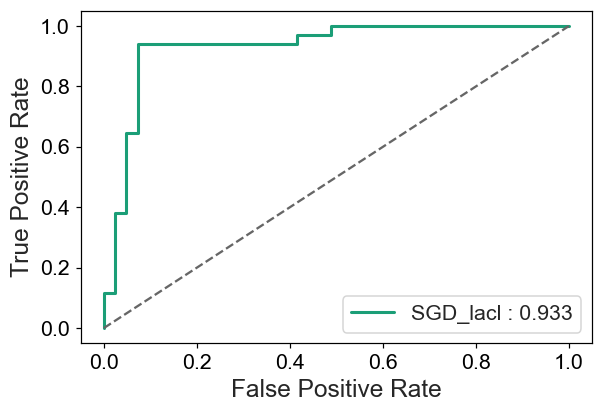

{'conf_mat': array([[38,  3],
        [ 2, 32]], dtype=int64),
 'accu': 0.9333333333333333,
 'auc': 0.9325681492109039}

In [88]:
sgd_clf_lacl = SGDClassifier(random_state=42, n_jobs=-1)
param=[{"learning_rate": ['constant','optimal','invscaling'], 'penalty': ['l2','l1','elasticnet'], 
        "eta0":np.linspace(0.8,1.2,num=21), "loss":["hinge","modified_huber","log"], 
         "class_weight":[None,"balanced"], }]
sgdbest_lacl = GridSearch_result(sgd_clf_lacl, X_train_3[index6], y_train_#, param, )
print(sgdbest_lacl)
ML_result(sgdbest_lacl[1], X_train_3[index6], y_train_3, "SGD_lacl", roc="sgd")

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


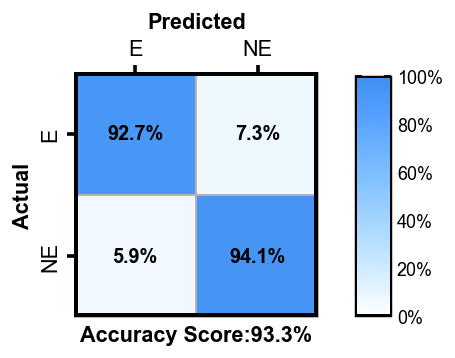

In [279]:
conf_mat_heatmap(np.array([[38,  3], [ 2, 32]]), label="sgd_2b", save=0, )

### SZ+CL
#### SGD
SGDClassifier(class_weight='balanced', eta0=0.11, learning_rate='constant',
              n_jobs=-1, random_state=42)

Run Time:13.62061357498169 s
[{'class_weight': 'balanced', 'eta0': 0.11, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'l2'}, SGDClassifier(class_weight='balanced', eta0=0.11, learning_rate='constant',
              n_jobs=-1, random_state=42)]


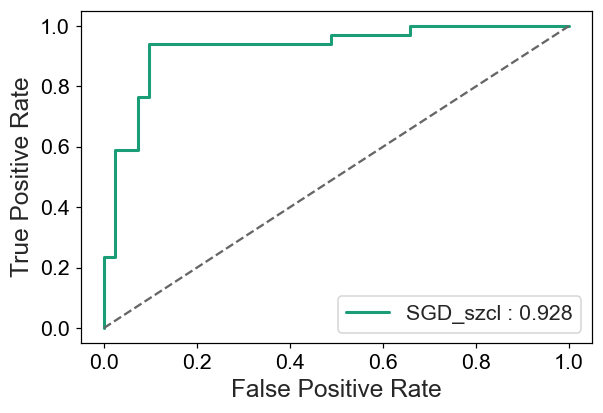

{'conf_mat': array([[37,  4],
        [ 2, 32]], dtype=int64),
 'accu': 0.92,
 'auc': 0.9275466284074606}

In [89]:
index5 = ["CLa","CLErr","SZa","SZErr"]
sgd_clf_szcl = SGDClassifier(random_state=42,n_jobs=-1)

param=[{"learning_rate": ['constant','optimal','invscaling'], 'penalty': ['l2','l1','elasticnet'], 
        "eta0":np.linspace(0.1,0.3,num=21), "loss":["hinge","modified_huber","log"], 
         "class_weight":[None,"balanced"], 
       }]
sgdbest_szcl = GridSearch_result(sgd_clf_szcl, X_train[index5], y_train, param, )
print(sgdbest_szcl)
ML_result(sgdbest_szcl[1], X_train_3[index5], y_train_3, "SGD_szcl", roc="sgd")

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


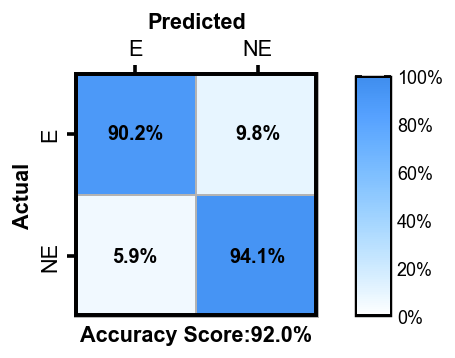

In [280]:
conf_mat_heatmap(np.array([[37,  4], [ 2, 32]]), label="sgd_2b", save=0, )

#### RF
RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=42)]

Run Time:42.83885598182678 s
[{'max_depth': None, 'max_features': 'auto', 'n_estimators': 15}, RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=42)]


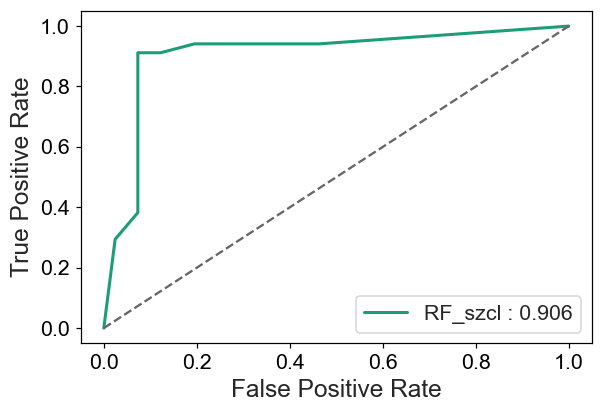

{'conf_mat': array([[38,  3],
        [ 3, 31]], dtype=int64),
 'accu': 0.92,
 'auc': 0.9056671449067433}

In [82]:
forest_clf_szcl = RandomForestClassifier(n_jobs=-1,random_state=42)
param2 = [{'n_estimators': range(2,20), "max_depth":[None], "max_features":["auto",3,4,2],  }]
rfbest_szcl = GridSearch_result(forest_clf_szcl, X_train[index5], y_train, param2,)
print(rfbest_szcl)
ML_result(rfbest_szcl[1], X_train_3[index5], y_train_3, "RF_szcl", roc="rf")

#### re_draw

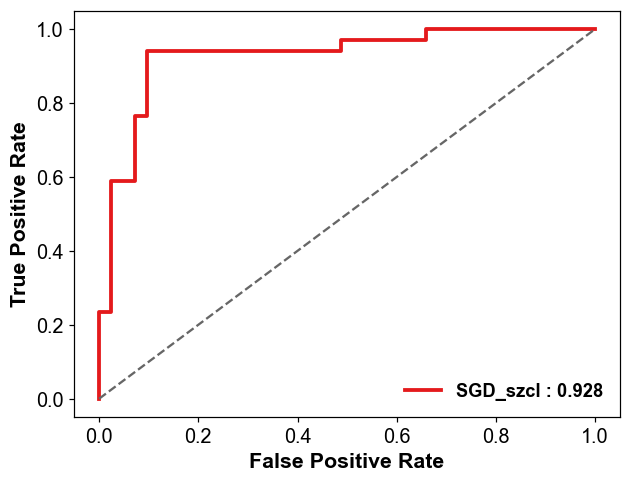

{'conf_mat': array([[37,  4],
        [ 2, 32]], dtype=int64),
 'accu': 0.92,
 'auc': 0.9275466284074606}

In [38]:
# SGD re_draw
sgd_clf3 = SGDClassifier(class_weight='balanced', eta0=0.11, learning_rate='constant',
              n_jobs=-1, random_state=42)
index5 = ["CLa","CLErr","SZa","SZErr"]
ML_result(sgd_clf3, X_train_3[index5], y_train_3, "SGD_szcl", roc="sgd",
          save_dir=save_dir, cmap=[sns.color_palette('Set1')[0]],)

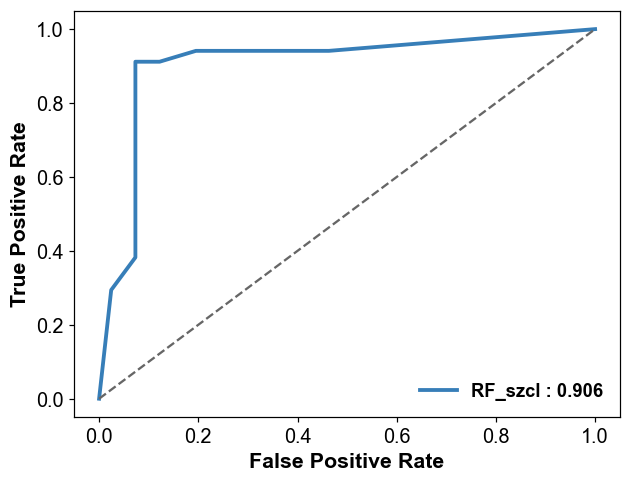

{'conf_mat': array([[38,  3],
        [ 3, 31]], dtype=int64),
 'accu': 0.92,
 'auc': 0.9056671449067433}

In [39]:
### RF re_draw
rfbest_lasz = RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=42)
ML_result(rfbest_lasz, X_train_3[index5], y_train_3, "RF_szcl", roc="rf",
          save_dir=save_dir, cmap=[sns.color_palette('Set1')[1]],)

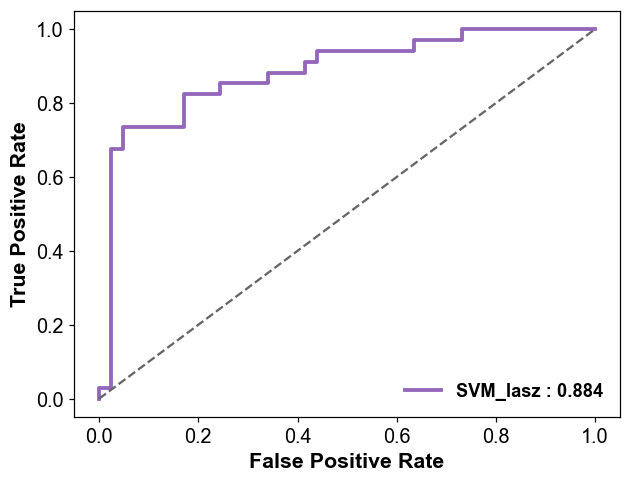

{'conf_mat': array([[39,  2],
        [ 9, 25]], dtype=int64),
 'accu': 0.8533333333333334,
 'auc': 0.8837876614060258}

In [34]:
### SVM re_draw
svcbest_lasz = SVC(C=0.8, coef0=0.7, gamma=0.1111111111111111, kernel='poly', 
                   probability=True, random_state=42)
ML_result(svcbest_lasz, X_train_3[index4], y_train_3, "SVM_lasz", roc="rf",
          save_dir=save_dir, cmap=[plt.get_cmap('tab10')(4)],)

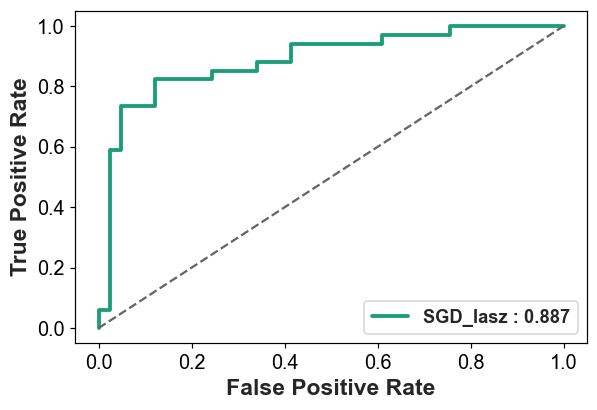

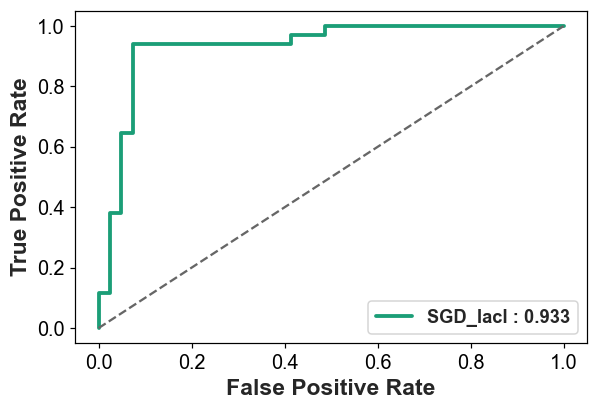

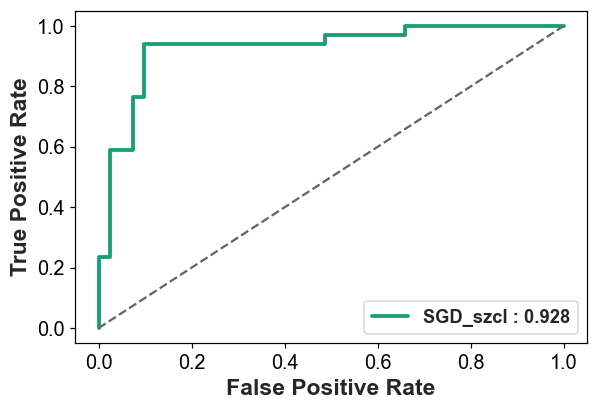

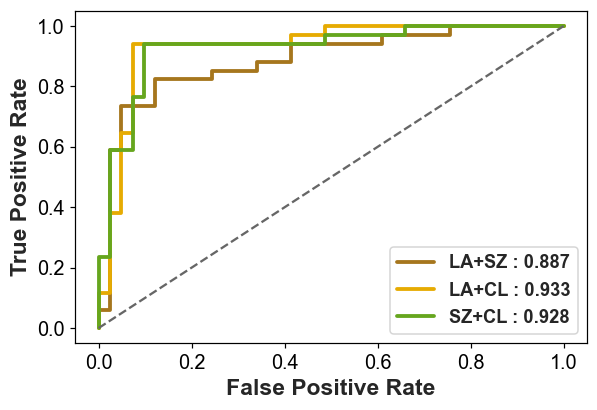

In [308]:
lasz1 = SGDClassifier(eta0=0.15, learning_rate='constant', loss='log', n_jobs=-1, random_state=42)
lasz2 = ML_result(lasz1, X_train[["LAa","LAErr","SZa","SZErr"]], y_train, "SGD_lasz",roc="sgd",feedback=1)
lacl1 = SGDClassifier(eta0=0.9, learning_rate='constant', n_jobs=-1, random_state=42)
lacl2 = ML_result(lacl1, X_train[["LAa","LAErr","CLa","CLErr"]], y_train, "SGD_lacl",roc="sgd",feedback=1)
szcl1 = SGDClassifier(class_weight='balanced', eta0=0.11, learning_rate='constant', n_jobs=-1, random_state=42)
szcl2 = ML_result(szcl1, X_train[["SZa","SZErr","CLa","CLErr"]], y_train, "SGD_szcl",roc="sgd",feedback=1)
plot_roc_curve([lasz2["fpr"],lacl2["fpr"],szcl2["fpr"]], [lasz2["tpr"],lacl2["tpr"],szcl2["tpr"]],
               label=["LA+SZ","LA+CL","SZ+CL"], auc=[lasz2["auc"],lacl2["auc"],szcl2["auc"]],
               cmap=sns.color_palette("Dark2_r"))

## on Test Set

In [71]:
sgdbest=SGDClassifier(alpha=0.055564444444444444, eta0=0.26126315789473686,
            learning_rate='invscaling', loss='log', n_jobs=-1, penalty='l1',
            power_t=0.07357142857142857, random_state=42)
sgdbest.fit(X_train_3, y_train_3)

SGDClassifier(alpha=0.055564444444444444, eta0=0.26126315789473686,
              learning_rate='invscaling', loss='log', n_jobs=-1, penalty='l1',
              power_t=0.07357142857142857, random_state=42)

[[10  1]
 [ 1  7]]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


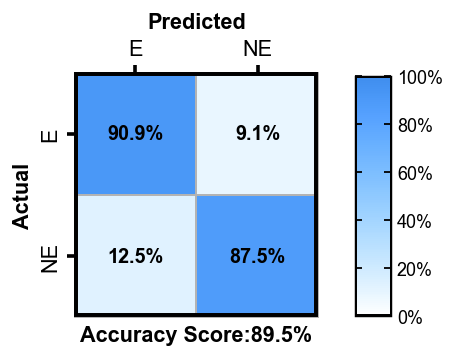

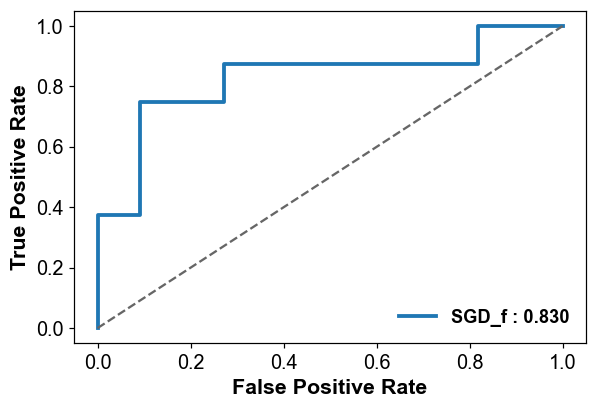

In [74]:
final_pred_SGD = sgdbest.predict(X_test)
confmat = confusion_matrix(y_test, final_pred_SGD)
print(confmat)
conf_mat_heatmap(confmat, rect_set=rect_set, title="test", save_dir=save_dir)

f_test_scores = cross_val_predict(sgdbest[1], X_test, y_test, cv=3, method="decision_function")
fpr1, tpr1, thresholds1 = roc_curve(y_test, f_test_scores)
auc1 = roc_auc_score(y_test, f_test_scores)
plot_roc_curve([fpr1], [tpr1], label=["SGD_f"], auc=[auc1], cmap=None)